In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( enum.Enum ):
    _10SEC = 0
    _10SEC_AVG = 1
    _30SEC = 2
    _30SEC_AVG = 3
    _1MIN = 4
    _1MIN_AVG = 5

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', 'datasets' ]

df = {}
df[ DF._10SEC ] = pd.read_csv( os.path.join( *path, 'ds-residential-10sec.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._10SEC_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-10sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._30SEC ] = pd.read_csv( os.path.join( *path, 'ds-residential-30sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._30SEC_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-30sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._1MIN ] = pd.read_csv( os.path.join( *path, 'ds-residential-1min-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._1MIN_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-1min-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._10SEC: 1,
    DF._10SEC_AVG: 1,
    DF._30SEC: 1,
    DF._30SEC_AVG: 1,
    DF._1MIN: 1,
    DF._1MIN_AVG: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._10SEC Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC Counter({'L': 16325, 'H': 16317, 'E': 16311, 'M': 16294})

Before balancing: DF._10SEC_AVG Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC_AVG Counter({'E': 16330, 'L': 16325, 'H': 16323, 'M': 16305})

Before balancing: DF._30SEC Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC Counter({'H': 5452, 'L': 5450, 'E': 5442, 'M': 5441})

Before balancing: DF._30SEC_AVG Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC_AVG Counter({'H': 5452, 'L': 5450, 'E': 5442, 'M': 5441})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'M': 2734, 'H': 2732, 'L': 2730, 'E': 2730})

Before balancing: DF._1MIN_AVG Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN_AVG Counter({'M': 2734, 'H': 2732, 'L': 2730, 'E': 2730})



## Training

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from ml.classification import *

params_knn = [ { 
    'n_neighbors': [ 1, 3, 5 ], 
    'p': [ 2 ], # mikowsky distance = euclidian distance
    'algorithm': [ 'ball_tree', 'kd_tree' ] # removed brute force due to the dataset size
} ]

grids = { 
    DF._10SEC: None,
    DF._10SEC_AVG: None,
    DF._30SEC: None,
    DF._30SEC_AVG: None,
    DF._1MIN: None,
    DF._1MIN_AVG: None
}

### Regular

Dataset  DF._1MIN_AVG 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9959272962475157
Test Accuracy:  0.9708249496981891
Exception arised while trying to use decision_function, predict_proba will be used instead.
Test ROCauc (OvR): 0.9573599336093492

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.97      0.96      0.97       183
           H       0.91      0.87      0.89        23
           L       0.98      0.99      0.98       673
           M       0.95      0.90      0.92       115

    accuracy                           0.97       994
   macro avg       0.95      0.93      0.94       994
weighted avg       0.97      0.97      0.97       994


CPU times: user 35.5 s, sys: 159 ms, total: 35.7 s
Wall time: 35.6 s


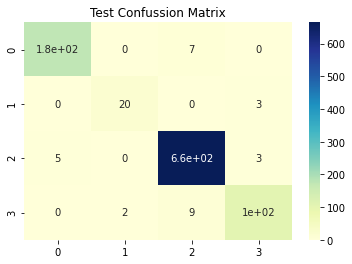

In [5]:
%%time
for k, d in df.items():
    if( k != DF._10SEC and k != DF._10SEC_AVG and k != DF._30SEC and k != DF._30SEC_AVG and k != DF._1MIN ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                KNeighborsClassifier(), params_knn, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], plot_cmatrix = True )

# Evaluation

In [6]:
from ml.evaluation import *

## Learning Curves

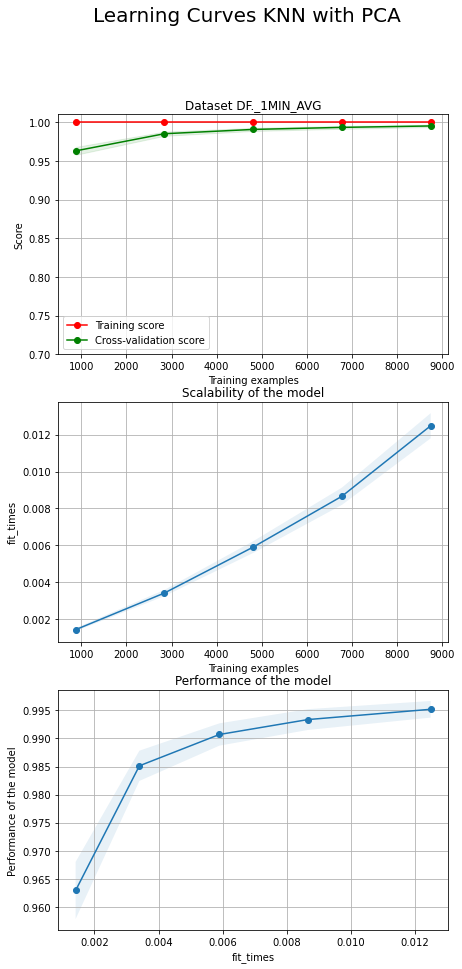

CPU times: user 1.58 s, sys: 123 ms, total: 1.71 s
Wall time: 26 s


In [7]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in [ DF._10SEC, DF._10SEC_AVG, DF._30SEC, DF._30SEC_AVG, DF._1MIN ] ]
plot_learning_curves( temp, grids, 'KNN' )